# 16. 다음에 볼 영화 예측하기

In [1]:
import pandas
import tensorflow
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


### data load

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [4]:
data['UserId'].nunique()

6040

### Session Length

In [5]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [7]:
session_length.min(), session_length.max()

(20, 2314)

In [8]:
session_length.quantile(0.999)

1343.181000000005

In [9]:
long_session = session_length[session_length==200].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
406366,2438,908,3,2000-11-14 17:28:41
406379,2438,2294,3,2000-11-14 17:28:41
406412,2438,3812,5,2000-11-14 17:28:41
406418,2438,3835,2,2000-11-14 17:28:41
406427,2438,1186,4,2000-11-14 17:28:41
...,...,...,...,...
406356,2438,3948,4,2001-01-18 04:27:56
406461,2438,2502,4,2001-02-04 04:46:41
406372,2438,1466,4,2001-02-04 21:43:09
406413,2438,1131,5,2001-04-13 02:08:11


In [10]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

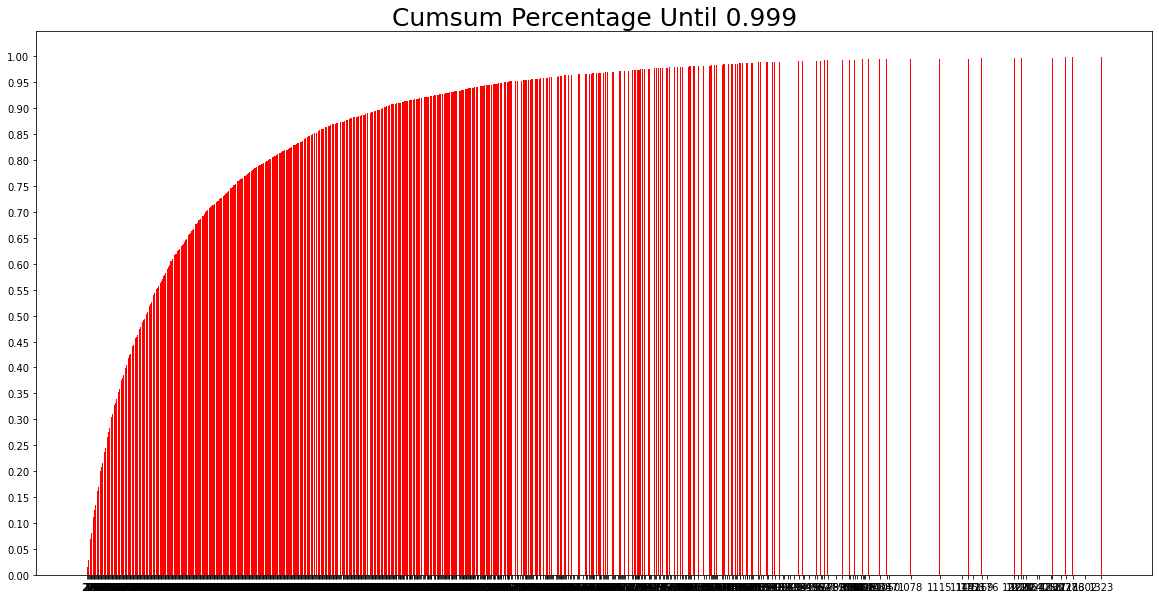

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=25)
plt.show()

### Session Time

In [12]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [13]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [14]:
# month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
# data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

In [15]:
#rate는 2이상만 사용한다. 
data = data[data['Rating'] > 2]   
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [16]:
data['UserId'].nunique()

6039

###  Data Cleansing

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

In [18]:
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

In [19]:
def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [20]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [21]:
data = data.sort_values(by=['Time'])
data

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
999873,6040,593,5,2000-04-25 23:05:54
1000153,6040,2384,4,2000-04-25 23:05:54
1000192,6040,2019,5,2000-04-25 23:06:17
1000007,6040,1961,4,2000-04-25 23:06:17
...,...,...,...,...
825526,4958,3489,4,2003-02-28 17:45:20
825438,4958,1407,5,2003-02-28 17:47:23
825731,4958,2634,3,2003-02-28 17:49:08
825724,4958,3264,4,2003-02-28 17:49:08


### Train / Valid / Test split

In [22]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    #after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [23]:
final_time = data['Time'].max()
final_time

Timestamp('2003-02-28 17:49:50')

In [24]:
session_last_time = data.groupby('Time')['Time'].max()
session_last_time

Time
2000-04-25 23:05:32   2000-04-25 23:05:32
2000-04-25 23:05:54   2000-04-25 23:05:54
2000-04-25 23:06:17   2000-04-25 23:06:17
2000-04-25 23:07:36   2000-04-25 23:07:36
2000-04-25 23:09:51   2000-04-25 23:09:51
                              ...        
2003-02-28 17:44:20   2003-02-28 17:44:20
2003-02-28 17:45:20   2003-02-28 17:45:20
2003-02-28 17:47:23   2003-02-28 17:47:23
2003-02-28 17:49:08   2003-02-28 17:49:08
2003-02-28 17:49:50   2003-02-28 17:49:50
Name: Time, Length: 412620, dtype: datetime64[ns]

In [25]:
n_days=180
session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
session_in_train

DatetimeIndex(['2000-04-25 23:05:32', '2000-04-25 23:05:54',
               '2000-04-25 23:06:17', '2000-04-25 23:07:36',
               '2000-04-25 23:09:51', '2000-04-25 23:10:19',
               '2000-04-25 23:10:57', '2000-04-25 23:11:45',
               '2000-04-25 23:14:08', '2000-04-25 23:14:35',
               ...
               '2002-08-31 17:59:05', '2002-08-31 18:00:17',
               '2002-08-31 18:00:50', '2002-08-31 18:01:11',
               '2002-08-31 20:38:06', '2002-08-31 23:43:05',
               '2002-09-01 00:14:13', '2002-09-01 02:22:25',
               '2002-09-01 04:16:16', '2002-09-01 04:20:59'],
              dtype='datetime64[ns]', name='Time', length=407326, freq=None)

In [26]:
n_days = 180
session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index
session_in_test

DatetimeIndex(['2002-09-01 19:41:39', '2002-09-01 19:43:16',
               '2002-09-01 19:44:55', '2002-09-01 19:45:08',
               '2002-09-01 19:58:42', '2002-09-01 21:34:42',
               '2002-09-01 21:39:55', '2002-09-01 21:53:50',
               '2002-09-01 21:54:15', '2002-09-01 22:10:14',
               ...
               '2003-02-27 23:31:15', '2003-02-28 00:51:39',
               '2003-02-28 13:11:19', '2003-02-28 13:12:12',
               '2003-02-28 15:05:11', '2003-02-28 17:44:20',
               '2003-02-28 17:45:20', '2003-02-28 17:47:23',
               '2003-02-28 17:49:08', '2003-02-28 17:49:50'],
              dtype='datetime64[ns]', name='Time', length=5294, freq=None)

In [27]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [28]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [29]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 818736
	 Sessions: 6036
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:14:13

* valid Set Stats Info
	 Events: 9771
	 Sessions: 390
	 Items: 2348
	 First Time : 2002-03-05 04:24:20
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7282
	 Sessions: 333
	 Items: 2049
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [30]:
#data[data['UserId'] == 150]

In [31]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [32]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

###  SessionDataset

In [33]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.user_offsets = self.get_user_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())

    def get_user_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()  #누적으로 계산된 합
        
        return offsets

In [34]:
offsets = np.zeros(val['UserId'].nunique() + 1, dtype=np.int32)
offsets

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
tr['UserId'].nunique()

6036

In [36]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000192,6040,2019,5,2000-04-25 23:06:17,3
1000007,6040,1961,4,2000-04-25 23:06:17,4
999980,6040,3505,4,2000-04-25 23:07:36,5
999967,6040,3111,5,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999877,6040,1419,3,2000-04-25 23:07:36,8
999868,6040,573,4,2000-04-25 23:07:36,9


In [37]:
tr_dataset.user_offsets

array([     0,     53,    169, ..., 818341, 818460, 818736], dtype=int32)

In [38]:
tr_dataset.user_idx

array([   0,    1,    2, ..., 6033, 6034, 6035])

### SessionDataLoader

In [39]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1
            for i in range(min_len):
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)
        last_session = self.batch_size - 1
        start = self.dataset.user_offsets[self.dataset.user_idx[first_iters]]
        end = self.dataset.user_offsets[self.dataset.user_idx[first_iters] + 1]
        mask = np.array([])
        finished = False
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]

        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i
            if new_session > self.dataset.user_idx[-1]:
                finished = True
                break

            start[idx] = self.dataset.user_offsets[self.dataset.user_idx[new_session]]
            end[idx] = self.dataset.user_offsets[self.dataset.user_idx[new_session] + 1]

        last_session += len(mask)
        return start, end, mask, last_session, finished

In [40]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000192,6040,2019,5,2000-04-25 23:06:17,3
1000007,6040,1961,4,2000-04-25 23:06:17,4
999980,6040,3505,4,2000-04-25 23:07:36,5
999967,6040,3111,5,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999877,6040,1419,3,2000-04-25 23:07:36,8
999868,6040,573,4,2000-04-25 23:07:36,9


In [41]:
iter_ex = iter(tr_data_loader)

In [42]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53   3 193]
Label Item Idx are :       [  1  54  14 165]
Previous Masked Input Idx are []


## Modeling

- mrr은 정답 아이템이 나온 순번의 역수 값. 정답 아이템이 추천 결과 앞쪽일수록 지표가 높음
- recall은 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋기 때문에 쓰는 성능지표

In [43]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [45]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [46]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)  #batchsize

In [47]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    503850    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [48]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")

In [49]:
def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')
    hidden_states = gru_layer.states[0].numpy()
    for elt in mask:
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states=hidden_states)

In [50]:
def get_metrics(data, model, args, k: int): 
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [51]:
train_model(model, args)

Evaluation:  14%|█▍        | 5/36 [00:05<00:35,  1.15s/it]


	 - Recall@20 epoch 1: 0.050000
	 - MRR@20    epoch 1: 0.011959



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.07s/it]


	 - Recall@20 epoch 2: 0.077344
	 - MRR@20    epoch 2: 0.017372



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.08s/it]

	 - Recall@20 epoch 3: 0.085938
	 - MRR@20    epoch 3: 0.023073



### Inference

In [52]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   7%|▋         | 2/27 [00:02<00:26,  1.05s/it]

	 - Recall@20: 0.076172
	 - MRR@20: 0.019433



## 여러 가지 시도 1

- batch_size = 128

- hsz = 50

- drop_rate = 0.1

- lr = 0.001

- epochs = 10

- k = 20

In [53]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [54]:
model2 = create_model(args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [55]:
train_model(model2, args2)

Evaluation:  47%|████▋     | 34/73 [00:19<00:22,  1.77it/s]


	 - Recall@20 epoch 1: 0.075138
	 - MRR@20    epoch 1: 0.017050



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.81it/s]


	 - Recall@20 epoch 2: 0.103171
	 - MRR@20    epoch 2: 0.023770



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.81it/s]


	 - Recall@20 epoch 3: 0.110524
	 - MRR@20    epoch 3: 0.025543



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.80it/s]


	 - Recall@20 epoch 4: 0.111903
	 - MRR@20    epoch 4: 0.025614



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.84it/s]


	 - Recall@20 epoch 5: 0.111443
	 - MRR@20    epoch 5: 0.026265



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.82it/s]


	 - Recall@20 epoch 6: 0.113971
	 - MRR@20    epoch 6: 0.026499



Evaluation:  47%|████▋     | 34/73 [00:19<00:21,  1.78it/s]


	 - Recall@20 epoch 7: 0.116039
	 - MRR@20    epoch 7: 0.027779



Evaluation:  47%|████▋     | 34/73 [00:19<00:21,  1.77it/s]


	 - Recall@20 epoch 8: 0.114660
	 - MRR@20    epoch 8: 0.028066



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.82it/s]


	 - Recall@20 epoch 9: 0.115349
	 - MRR@20    epoch 9: 0.028413



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.82it/s]

	 - Recall@20 epoch 10: 0.116268
	 - MRR@20    epoch 10: 0.028989



In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model2, args2, test)

## 여러 가지 시도 2

- batch_size = 128

- hsz = 50

- drop_rate = 0.2

- lr = 0.001

- epochs = 10

- k = 20

In [57]:
args3 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20)
model3 = create_model(args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [58]:
train_model(model3, args3)

Evaluation:  47%|████▋     | 34/73 [00:19<00:22,  1.73it/s]


	 - Recall@20 epoch 1: 0.072840
	 - MRR@20    epoch 1: 0.017453



Evaluation:  47%|████▋     | 34/73 [00:19<00:22,  1.77it/s]


	 - Recall@20 epoch 2: 0.099265
	 - MRR@20    epoch 2: 0.020983



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.79it/s]


	 - Recall@20 epoch 3: 0.110754
	 - MRR@20    epoch 3: 0.024564



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.81it/s]


	 - Recall@20 epoch 4: 0.114660
	 - MRR@20    epoch 4: 0.026656



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.80it/s]


	 - Recall@20 epoch 5: 0.115349
	 - MRR@20    epoch 5: 0.026816



Evaluation:  47%|████▋     | 34/73 [00:19<00:21,  1.78it/s]


	 - Recall@20 epoch 6: 0.114890
	 - MRR@20    epoch 6: 0.026840



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.80it/s]


	 - Recall@20 epoch 7: 0.116958
	 - MRR@20    epoch 7: 0.026762



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.82it/s]


	 - Recall@20 epoch 8: 0.116268
	 - MRR@20    epoch 8: 0.025911



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.80it/s]


	 - Recall@20 epoch 9: 0.114890
	 - MRR@20    epoch 9: 0.026323



Evaluation:  47%|████▋     | 34/73 [00:18<00:21,  1.81it/s]

	 - Recall@20 epoch 10: 0.114430
	 - MRR@20    epoch 10: 0.026375



In [60]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model3, args3, test)

Evaluation:  37%|███▋      | 20/54 [00:10<00:18,  1.84it/s]

	 - Recall@20: 0.117578
	 - MRR@20: 0.027364



## 여러 가지 시도 3

- batch_size = 256
- hsz = 50
- drop_rate = 0.2
- lr = 0.001
- epochs = 10
- k = 20

In [61]:
args4 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20)
model4 = create_model(args4)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    503850    
_________________________________________________________________
dropout_3 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (256, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [62]:
train_model(model4, args4)

Evaluation:  14%|█▍        | 5/36 [00:05<00:35,  1.14s/it]


	 - Recall@20 epoch 1: 0.044531
	 - MRR@20    epoch 1: 0.012759



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.10s/it]


	 - Recall@20 epoch 2: 0.073438
	 - MRR@20    epoch 2: 0.016869



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.10s/it]


	 - Recall@20 epoch 3: 0.082812
	 - MRR@20    epoch 3: 0.020078



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.11s/it]


	 - Recall@20 epoch 4: 0.088281
	 - MRR@20    epoch 4: 0.025852



Evaluation:  14%|█▍        | 5/36 [00:05<00:32,  1.06s/it]


	 - Recall@20 epoch 5: 0.091406
	 - MRR@20    epoch 5: 0.025250



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.09s/it]


	 - Recall@20 epoch 6: 0.086719
	 - MRR@20    epoch 6: 0.026553



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.08s/it]


	 - Recall@20 epoch 7: 0.096875
	 - MRR@20    epoch 7: 0.027075



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.10s/it]


	 - Recall@20 epoch 8: 0.100781
	 - MRR@20    epoch 8: 0.026989



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.10s/it]


	 - Recall@20 epoch 9: 0.101562
	 - MRR@20    epoch 9: 0.026998



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.07s/it]

	 - Recall@20 epoch 10: 0.101562
	 - MRR@20    epoch 10: 0.026881



In [63]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model4, args4, test)

Evaluation:   7%|▋         | 2/27 [00:02<00:28,  1.14s/it]

	 - Recall@20: 0.099609
	 - MRR@20: 0.028521



## Retrospection

train/valid/test를 split 하는 과정에서 data가 제대로 나누어지지 않았다. train/valid/test의 데이터가 겹치는 문제였는데 groupby기준을 userid가 아닌 time으로 하면서 해결을 하였다. userid로 groupby를 하게 되면 userid의 초반 데이터도 후반 데이터도 다 train 데이터로 들어가게 되서 이런 오류가 났던 것이다.

train_model에서도 학습이 되지 않는 오류가 있었는데 batchsize를 줄여주면서 해결이 되었다.